In [1]:
!pip install numpy matplotlib pillow scikit-image opencv-python


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Information Variation Within and Across Images


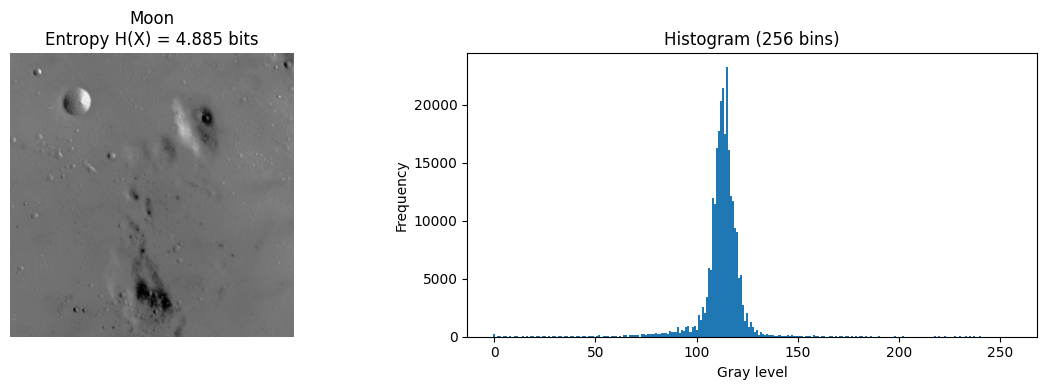

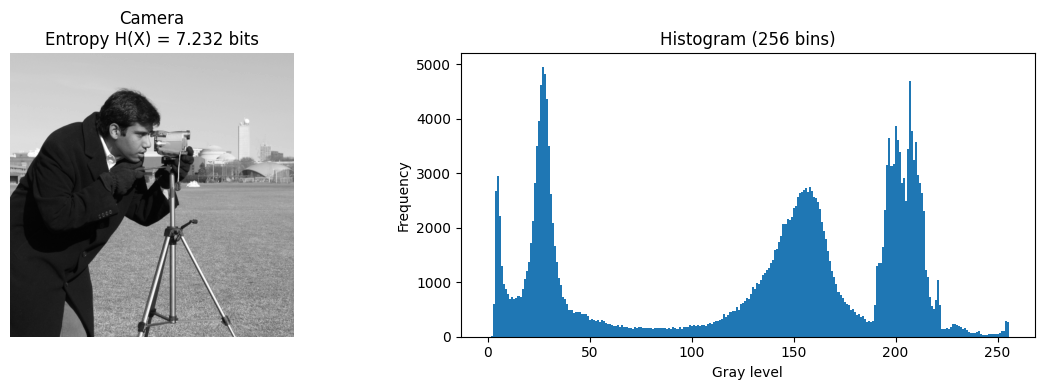

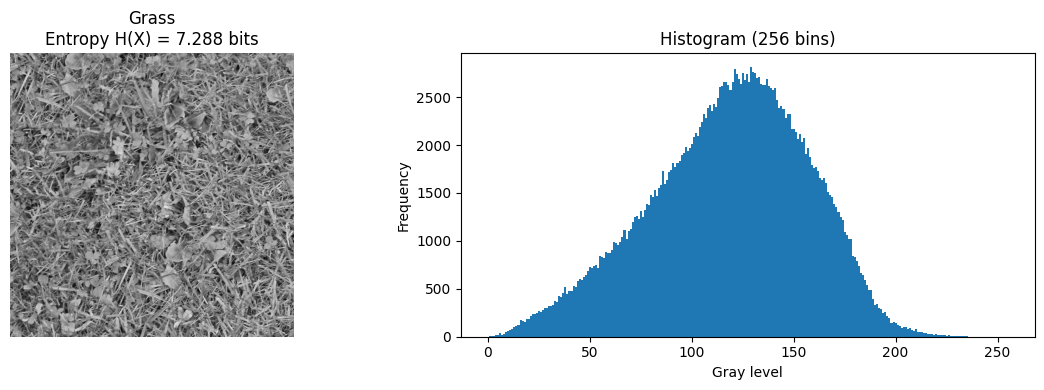

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color


def hist_entropy(image, bins=256):
    counts, _ = np.histogram(image, bins=bins, range=(0, 255))
    p = counts.astype(np.float64)

    if p.sum() == 0:
        return counts, 0.0

    p /= p.sum()
    p = p[p > 0]
    return counts, float(-np.sum(p * np.log2(p)))


def block_entropy_map(image, win):
    Hmap = np.zeros_like(image, dtype=np.float64)
    H, W = image.shape

    for i in range(0, H - win + 1, win):
        for j in range(0, W - win + 1, win):
            _, Hval = hist_entropy(image[i:i + win, j:j + win])
            Hmap[i:i + win, j:j + win] = Hval

    return Hmap


# 1. Compute and plot a 256-bin histogram and global entropy H(X) for each grayscaleimage. Label axes clearly.

img1 = data.moon()   
img2 = data.camera()                      
img3 = data.grass()                       

images = [img1, img2, img3]
titles = ["Moon", "Camera", "Grass"]

# --- Compute histograms and entropy ---
for img, title in zip(images, titles):
    img_255 = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img
    counts, H = hist_entropy(img_255)

    plt.figure(figsize=(12, 4))

    # show image
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{title}\nEntropy H(X) = {H:.3f} bits")
    plt.axis("off")

    # show histogram
    plt.subplot(1, 2, 2)
    plt.bar(range(256), counts, width=1.0, edgecolor="none")
    plt.title("Histogram (256 bins)")
    plt.xlabel("Gray level")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()


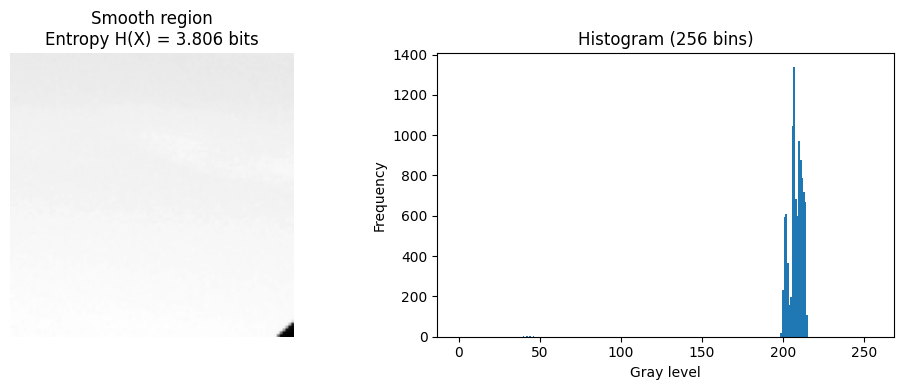

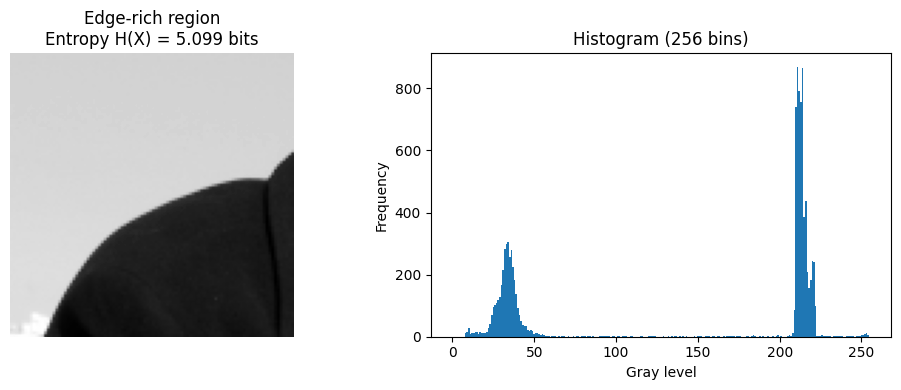

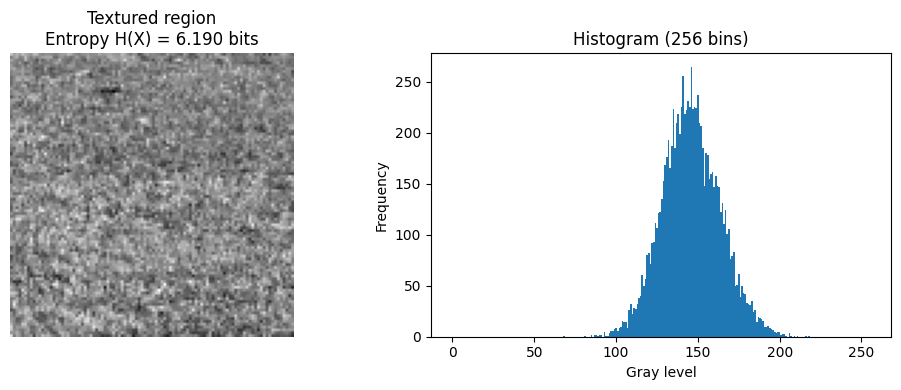

In [3]:
# 2. Select three square crops of equal size: (i) smooth region, (ii) edge-rich region, (iii)
# textured region. Compute histograms and entropy. Compare variability within one
# image and discuss what this means for compressibility

img = data.camera()

# --- Define three crops (adjust coordinates later if needed) ---
# Format: [row_start:row_end, col_start:col_end]
crop_smooth   = img[20:120, 40:140]    # smooth region
crop_edges    = img[80:180, 40:140]  # edge-rich region
crop_textured = img[400:500, 400:500]  # textured region

crops = [crop_smooth, crop_edges, crop_textured]
titles = ["Smooth region", "Edge-rich region", "Textured region"]

def hist_entropy(image, bins=256):
    counts, _ = np.histogram(image, bins=bins, range=(0, 255))
    p = counts.astype(np.float64)
    if p.sum() == 0:
        return counts, 0.0
    p /= p.sum()
    p = p[p > 0]
    return counts, float(-np.sum(p * np.log2(p)))


# --- Plot crops, histograms, and entropy ---
for crop, title in zip(crops, titles):
    counts, H = hist_entropy(crop)

    plt.figure(figsize=(10, 4))

    # Crop image
    plt.subplot(1, 2, 1)
    plt.imshow(crop, cmap="gray")
    plt.title(f"{title}\nEntropy H(X) = {H:.3f} bits")
    plt.axis("off")

    # Histogram
    plt.subplot(1, 2, 2)
    plt.bar(range(256), counts, width=1.0)
    plt.title("Histogram (256 bins)")
    plt.xlabel("Gray level")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

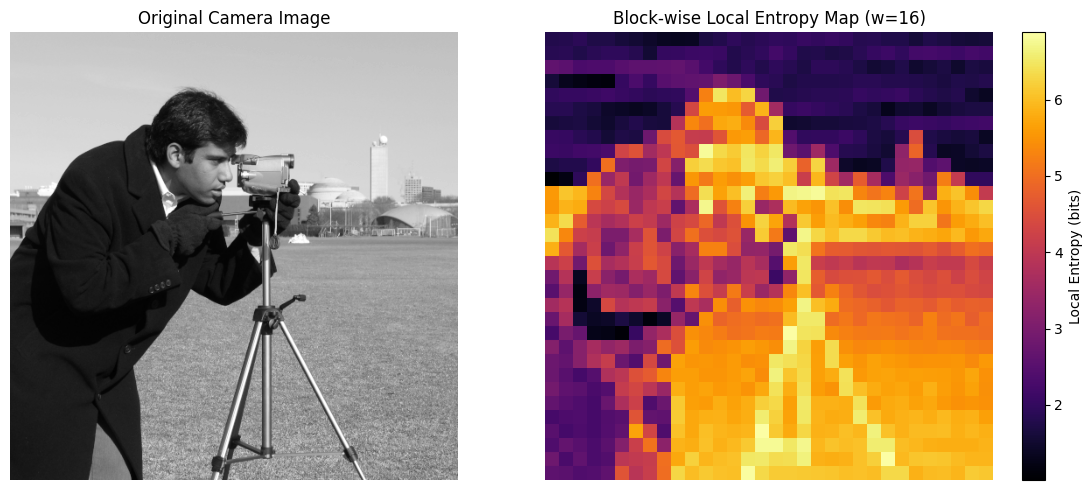

In [4]:
# Create a block-wise local entropy map using a sliding or tiled w × w window. Display
# as a heatmap and explain how high-entropy areas relate to visual structures.


# --- Compute local entropy map ---
win_size = 16  # block size (adjustable)
entropy_map = block_entropy_map(img, win_size)

# --- Plot original image and entropy heatmap ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Camera Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(entropy_map, cmap='inferno')  # 'inferno' highlights high values
plt.colorbar(label="Local Entropy (bits)")
plt.title(f"Block-wise Local Entropy Map (w={win_size})")
plt.axis("off")

plt.tight_layout()
plt.show()




# Prediction: Type and Length

In [2]:
import numpy as np

def predict_left(image):
    P = np.empty_like(image)
    P[:, 0] = image[:, 0]
    P[:, 1:] = image[:, :-1]
    return P

def predict_avg_lt(image):
    P = np.empty_like(image, dtype=np.float32)
    P[0, :] = image[0, :]
    P[:, 0] = image[:, 0]
    P[1:, 1:] = 0.5 * (image[1:, :-1].astype(np.float32) + image[:-1, 1:].astype(np.float32))
    return np.clip(np.rint(P), 0, 255).astype(np.uint8)

def predict_median_jpegls(image):
    H, W = image.shape
    P = np.empty_like(image, dtype=np.float32)
    P[0, :] = image[0, :]
    P[:, 0] = image[:, 0]

    A = image[1:, :-1].astype(np.int32)   # left
    B = image[:-1, 1:].astype(np.int32)   # top
    C = image[:-1, :-1].astype(np.int32)  # top-left

    # Initialize P_block
    P_block = np.zeros_like(A, dtype=np.float32)

    mask1 = C >= np.maximum(A, B)
    mask2 = C <= np.minimum(A, B)
    mask3 = ~(mask1 | mask2)  # else

    P_block[mask1] = np.minimum(A[mask1], B[mask1])
    P_block[mask2] = np.maximum(A[mask2], B[mask2])
    P_block[mask3] = A[mask3] + B[mask3] - C[mask3]

    P[1:, 1:] = P_block

    return np.clip(np.rint(P), 0, 255).astype(np.uint8)

def residual_entropy(image, pred):
    res = image.astype(np.int16) - pred.astype(np.int16)
    res = np.clip(res + 128, 0, 255).astype(np.uint8)
    counts, _ = np.histogram(res, bins=256, range=(0, 255))
    p = counts.astype(np.float64)
    if p.sum() == 0:
        return 0.0
    p /= p.sum()
    p = p[p > 0]
    return float(-np.sum(p * np.log2(p)))


img1 = data.moon()  
img2 = data.camera()                      
img3 = data.grass()                       

images = [img1, img2, img3]
titles = ["Moon", "Camera", "Grass"]


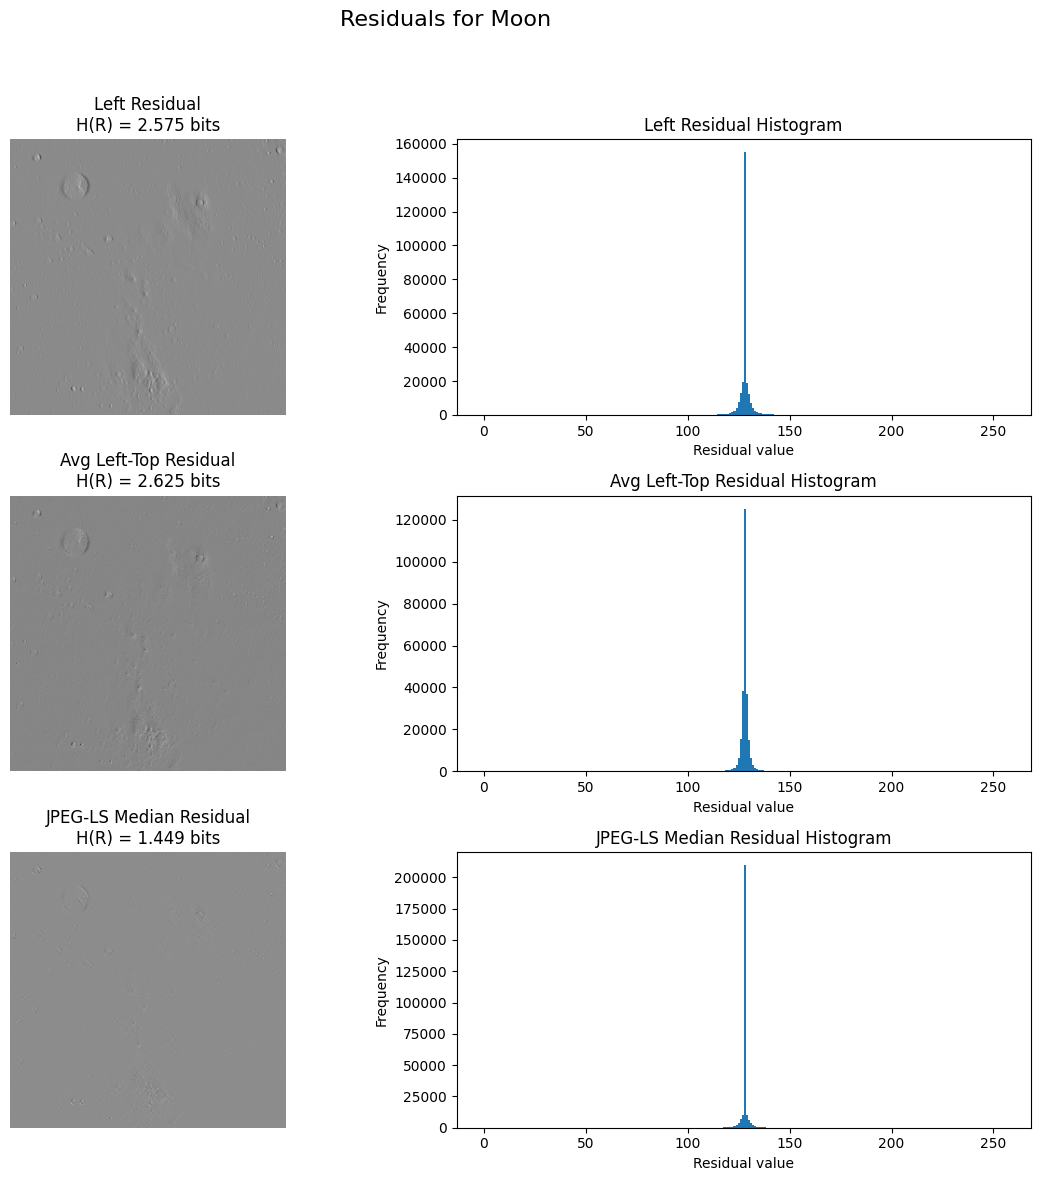

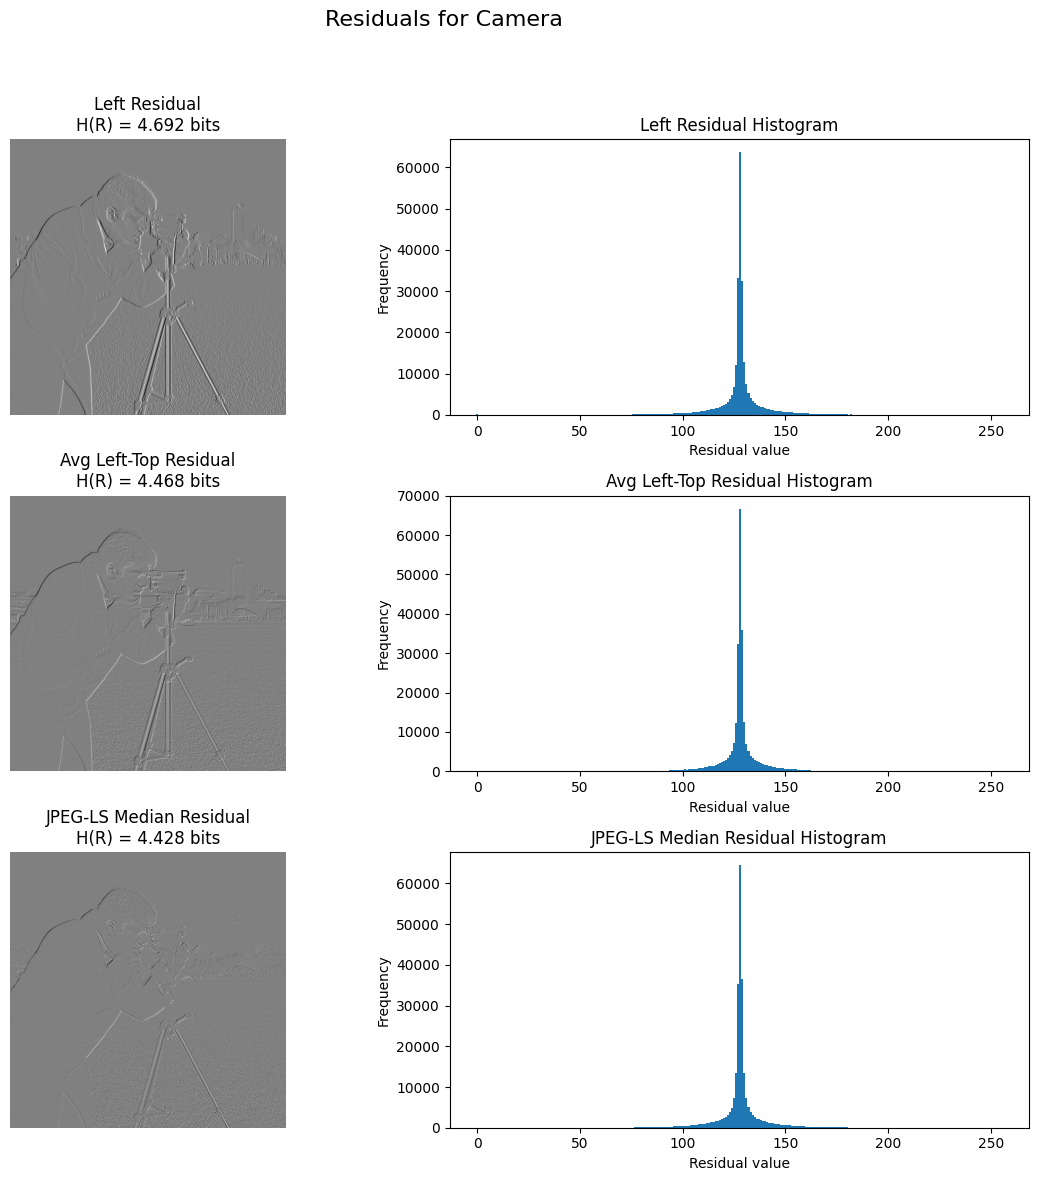

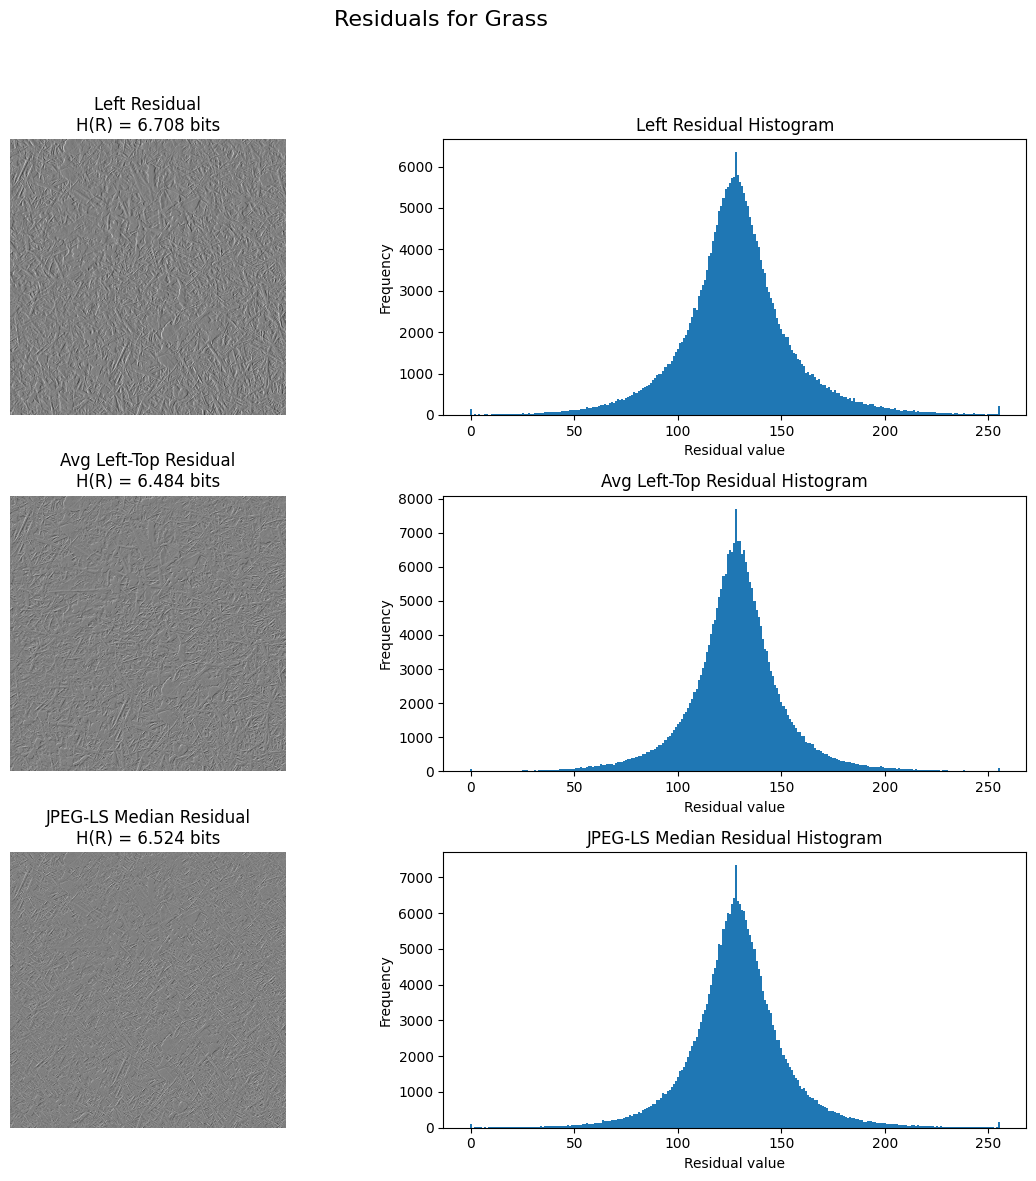

In [6]:
# 2. For each predictor, compute residuals R = X − Xˆ. Visualize residual images, plot
# residual histograms (shifted to [0,255]), and compute entropy H(R).

predictors = {
    "Left": predict_left,
    "Avg Left-Top": predict_avg_lt,
    "JPEG-LS Median": predict_median_jpegls
}


for img, title in zip(images, titles):
    plt.figure(figsize=(12, 12))
    plt.suptitle(f"Residuals for {title}", fontsize=16)
    
    for i, (pred_name, pred_func) in enumerate(predictors.items()):
        pred = pred_func(img)
        res = np.clip(img.astype(np.int16) - pred.astype(np.int16) + 128, 0, 255).astype(np.uint8)
        H_res = residual_entropy(img, pred)
        
        # residual image
        plt.subplot(3, 2, i*2 + 1)
        plt.imshow(res, cmap='gray')
        plt.title(f"{pred_name} Residual\nH(R) = {H_res:.3f} bits")
        plt.axis("off")
        
        # residual histogram
        plt.subplot(3, 2, i*2 + 2)
        counts, _ = np.histogram(res, bins=256, range=(0, 255))
        plt.bar(range(256), counts, width=1.0)
        plt.title(f"{pred_name} Residual Histogram")
        plt.xlabel("Residual value")
        plt.ylabel("Frequency")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [7]:
# Estimate conditional entropy H(Y | X) for horizontal neighbors using a joint histogram (Xi,j−1, Xi,j ). Compare this with H(R) for the left predictor and comment
# on similarities and differences.

def conditional_entropy_left(image):
    """
    Estimate H(Y|X) for horizontal neighbors using a joint histogram.
    X = left pixel, Y = current pixel
    """
    H, W = image.shape
    X = image[:, :-1].ravel()
    Y = image[:, 1:].ravel()
    
    # joint histogram
    joint_counts, _, _ = np.histogram2d(X, Y, bins=256, range=[[0,255],[0,255]])
    joint_probs = joint_counts / joint_counts.sum()
    
    # marginal for X
    px = joint_probs.sum(axis=1, keepdims=True)
    
    # conditional p(y|x)
    with np.errstate(divide='ignore', invalid='ignore'):
        py_given_x = np.divide(joint_probs, px)
        py_given_x[joint_probs==0] = 1  # to avoid log(0)
    
    H_cond = -np.sum(joint_probs * np.log2(py_given_x))
    return H_cond



for img, title in zip(images, titles):
    H_cond = conditional_entropy_left(img)
    pred_left = predict_left(img)
    H_res = residual_entropy(img, pred_left)
    
    print(f"{title}:")
    print(f"  H(Y|X) using joint histogram = {H_cond:.3f} bits")
    print(f"  H(R) using left predictor       = {H_res:.3f} bits")
    print()


Moon:
  H(Y|X) using joint histogram = 2.411 bits
  H(R) using left predictor       = 2.575 bits

Camera:
  H(Y|X) using joint histogram = 4.014 bits
  H(R) using left predictor       = 4.692 bits

Grass:
  H(Y|X) using joint histogram = 6.482 bits
  H(R) using left predictor       = 6.708 bits



# Transform Coding: DCT vs. KLT

In [3]:
import cv2
import numpy as np

def dct2(block):
    return cv2.dct(block.astype(np.float32))

def idct2(block):
    return cv2.idct(block.astype(np.float32))

def sample_patches(image, N, M, rng):
    H, W = image.shape
    patches = []
    for _ in range(M):
        i = rng.integers(0, H - N + 1)
        j = rng.integers(0, W - N + 1)
        p = image[i:i+N, j:j+N].astype(np.float32)
        patches.append(p - p.mean())
    return np.stack(patches)

def klt_from_patches(patches):
    M, N, _ = patches.shape
    X = patches.reshape(M, -1)
    C = np.cov(X, rowvar=False)
    w, V = np.linalg.eigh(C)
    idx = np.argsort(w)[::-1]
    return V[:, idx], w[idx]


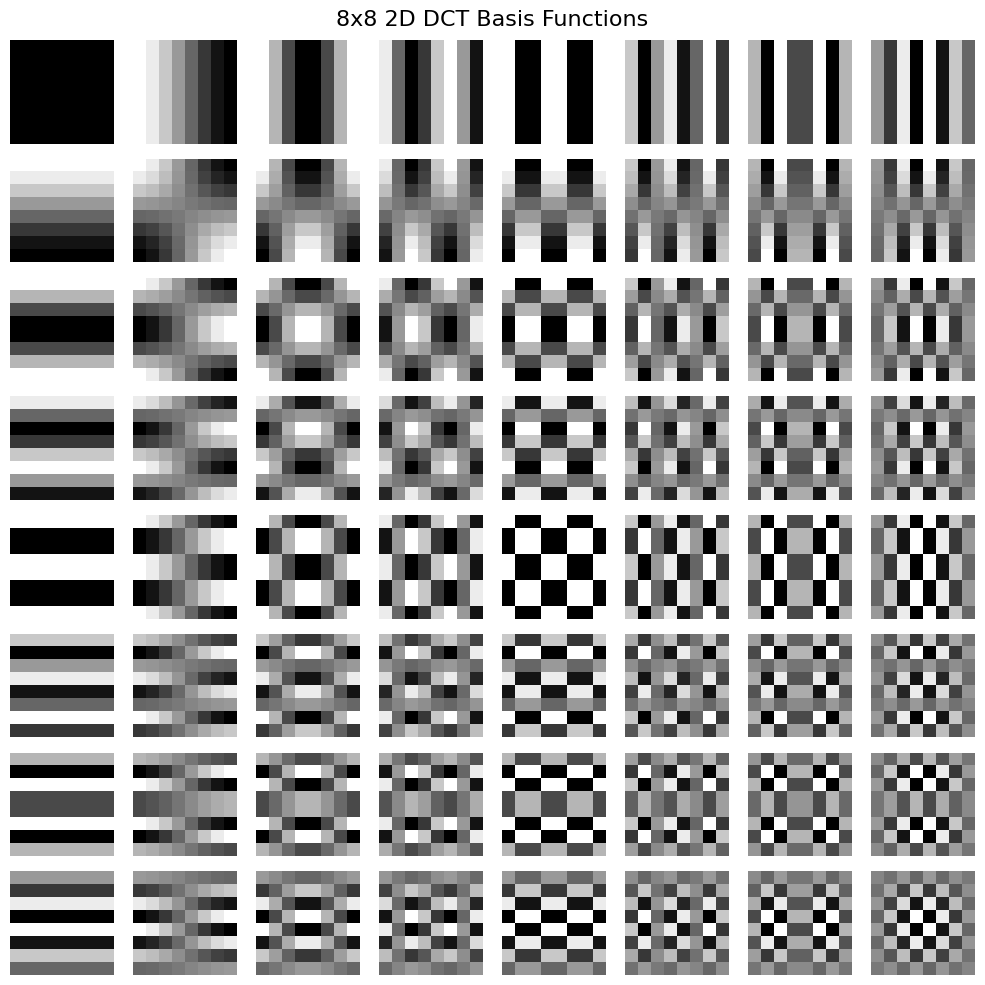

In [4]:
def dct_basis_grid(N):
    bases = np.zeros((N, N, N, N), dtype=np.float32)
    for u in range(N):
        for v in range(N):
            coeff = np.zeros((N, N), dtype=np.float32)
            coeff[u, v] = 1.0
            bases[u, v] = idct2(coeff)
    return bases

# Example: visualize 8x8 DCT basis functions separately
N = 8
bases = dct_basis_grid(N)

fig, axes = plt.subplots(N, N, figsize=(10, 10))
for u in range(N):
    for v in range(N):
        ax = axes[u, v]
        ax.imshow(bases[u, v], cmap='gray')
        ax.axis('off')
plt.suptitle(f"{N}x{N} 2D DCT Basis Functions", fontsize=16)
plt.tight_layout()
plt.show()

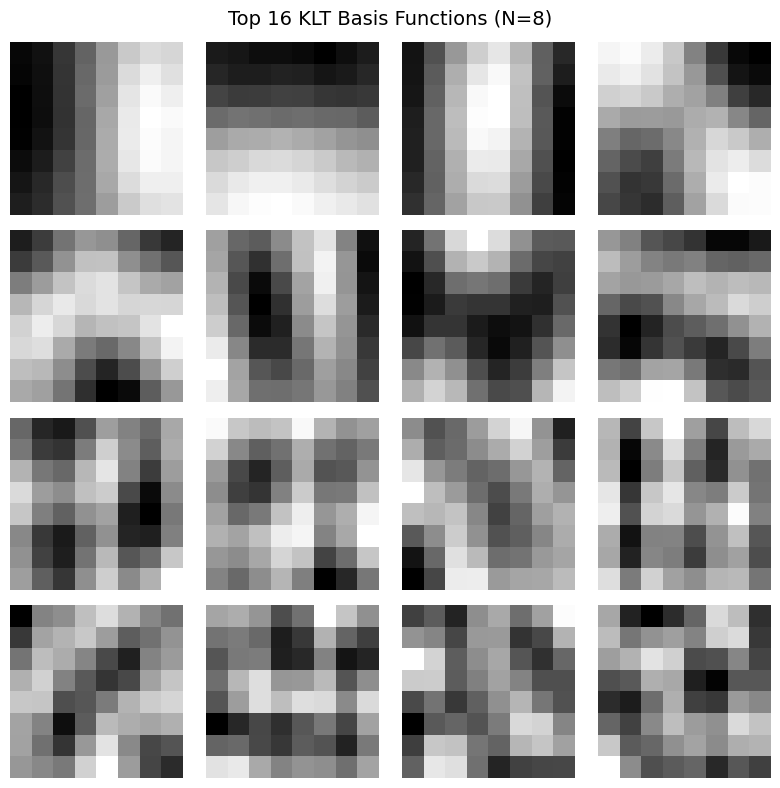

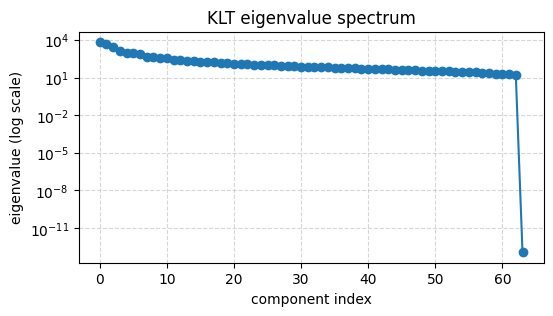

In [9]:
# 2. Build a KLT basis from zero-mean patches sampled from an image. Visualize leading
# basis functions and compare them to the DCT.

img = data.camera()
N = 8
M = 2000
rng = np.random.default_rng(0)
patches = sample_patches(img, N, M, rng)

# compute KLT
V, w = klt_from_patches(patches)        # V: eigenvectors (N*N, N*N), w: eigenvalues
klt_bases = V.T.reshape(-1, N, N)       # reshape each eigenvector into N x N

# ---- visualization ----
K = 16  # number of leading basis functions to show
rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(8, 8))

for i in range(K):
    r, c = divmod(i, cols)
    ax = axes[r, c]
    b = klt_bases[i]
    b = (b - b.min()) / (b.max() - b.min() + 1e-12)
    ax.imshow(b, cmap='gray')
    ax.axis('off')

axes[0, 0].set_ylabel("KLT", fontsize=12)
plt.suptitle(f"Top {K} KLT Basis Functions (N={N})", fontsize=14)
plt.tight_layout()
plt.show()

# also show eigenvalue spectrum to see variance captured
plt.figure(figsize=(6,3))
plt.plot(w[:64], marker='o')
plt.yscale('log')
plt.title("KLT eigenvalue spectrum")
plt.xlabel("component index")
plt.ylabel("eigenvalue (log scale)")
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()


Extracted 4096 non-overlapping 8x8 blocks

Energy Compaction Analysis:
Retention Ratio | DCT PSNR (dB) | KLT PSNR (dB) | DCT Energy Ratio | KLT Energy Ratio
-------------------------------------------------------------------------------------
           0.1 |        27.34 |        30.13 |           0.995 |           0.997
           0.2 |        29.35 |        33.05 |           0.997 |           0.999
           0.3 |        31.53 |        35.85 |           0.998 |           0.999
           0.4 |        32.55 |        38.23 |           0.998 |           1.000
           0.5 |        34.44 |        41.23 |           0.999 |           1.000
           0.6 |        35.57 |        44.22 |           0.999 |           1.000
           0.7 |        37.36 |        47.83 |           0.999 |           1.000
           0.8 |        39.68 |        53.62 |           1.000 |           1.000
           0.9 |        43.28 |        61.84 |           1.000 |           1.000
           1.0 |       162.7

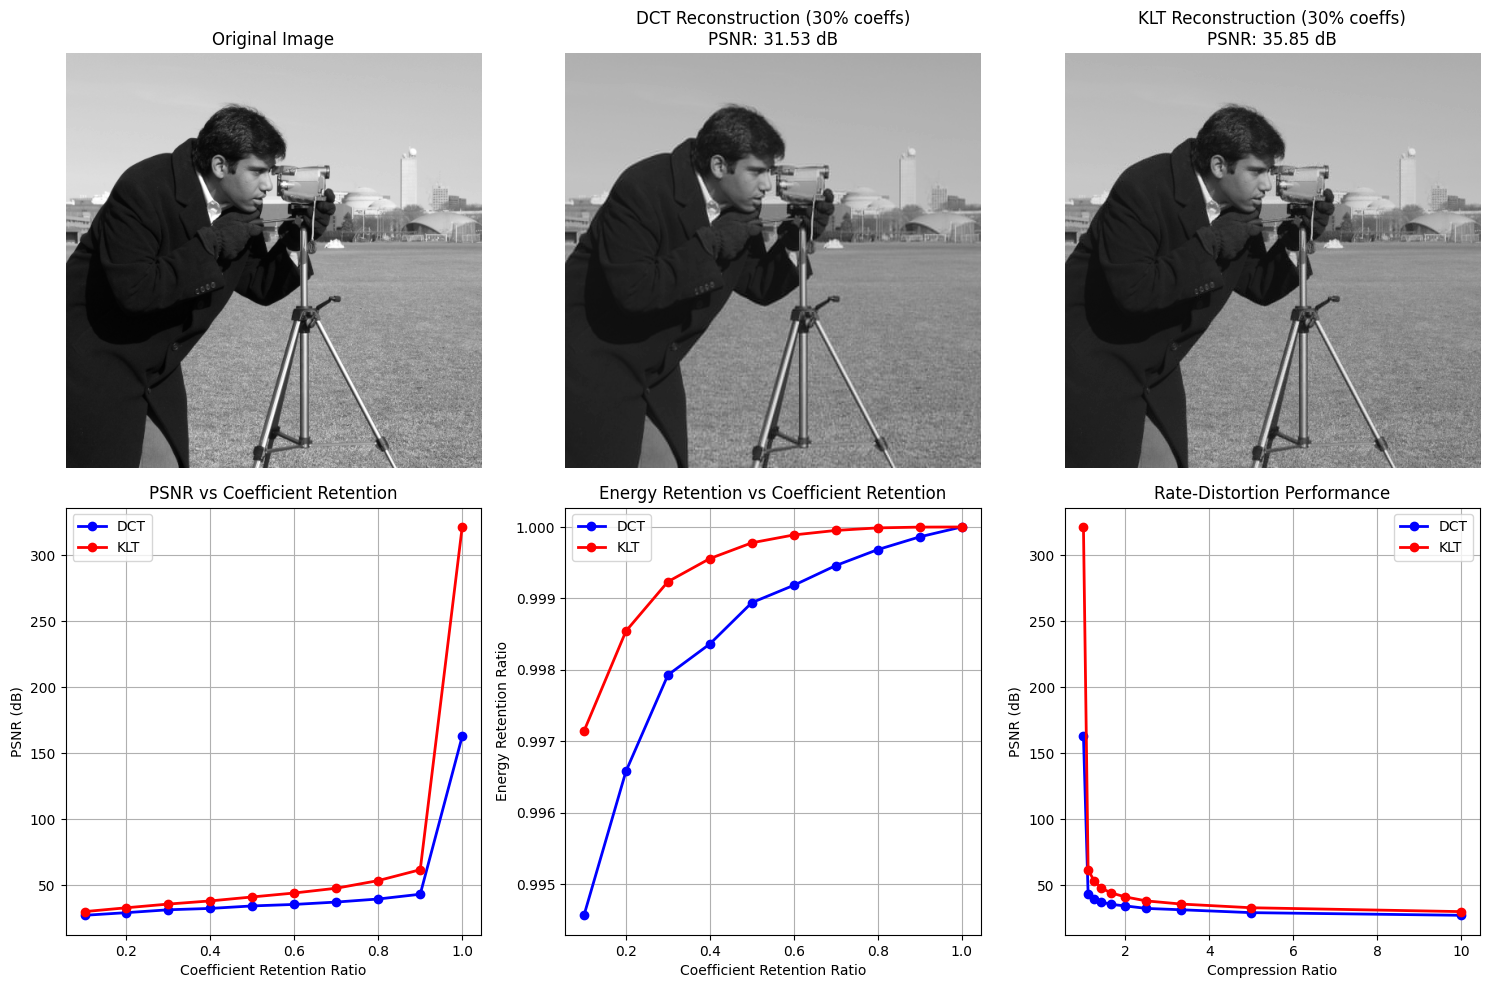


Summary for 30% coefficient retention:
DCT - PSNR: 31.53 dB, Energy Retention: 0.998
KLT - PSNR: 35.85 dB, Energy Retention: 0.999


In [11]:


def extract_non_overlapping_blocks(image, N):
    """Extract non-overlapping N x N blocks from image"""
    H, W = image.shape
    # Crop image to make it divisible by N
    H_new = (H // N) * N
    W_new = (W // N) * N
    image_cropped = image[:H_new, :W_new]
    
    blocks = []
    positions = []
    for i in range(0, H_new, N):
        for j in range(0, W_new, N):
            block = image_cropped[i:i+N, j:j+N].astype(np.float32)
            blocks.append(block)
            positions.append((i, j))
    
    return np.array(blocks), positions, (H_new, W_new)

def reconstruct_from_blocks(blocks, positions, image_shape):
    """Reconstruct image from blocks"""
    H, W = image_shape
    reconstructed = np.zeros((H, W), dtype=np.float32)
    for (i, j), block in zip(positions, blocks):
        reconstructed[i:i+block.shape[0], j:j+block.shape[1]] = block
    return reconstructed

def apply_transform_and_retain_coefficients(blocks, transform, basis=None, retain_ratio=0.5):
    """
    Apply transform to blocks and retain only a fraction of coefficients
    """
    N = blocks.shape[1]
    transformed_blocks = []
    retained_coeffs_list = []
    
    for block in blocks:
        # Zero-mean the block
        block_zero_mean = block - block.mean()
        
        if transform == 'dct':
            # Apply DCT
            coeffs = dct2(block_zero_mean)
        elif transform == 'klt' and basis is not None:
            # Apply KLT: project onto KLT basis
            block_flat = block_zero_mean.reshape(-1)
            coeffs = basis.T @ block_flat
            coeffs = coeffs.reshape(N, N)
        
        # Determine number of coefficients to retain
        total_coeffs = N * N
        retain_count = int(total_coeffs * retain_ratio)
        
        # Create mask for retained coefficients (zigzag order for DCT, largest magnitude for KLT)
        if transform == 'dct':
            # Use zigzag scanning for DCT
            mask = zigzag_mask(N, retain_count)
        else:
            # For KLT, retain coefficients with largest magnitude
            coeffs_flat = coeffs.reshape(-1)
            indices = np.argsort(np.abs(coeffs_flat))[::-1][:retain_count]
            mask = np.zeros(total_coeffs, dtype=bool)
            mask[indices] = True
            mask = mask.reshape(N, N)
        
        # Retain only selected coefficients
        retained_coeffs = coeffs * mask
        retained_coeffs_list.append(retained_coeffs)
        
        # Apply inverse transform
        if transform == 'dct':
            reconstructed_block = idct2(retained_coeffs)
        elif transform == 'klt' and basis is not None:
            # Inverse KLT: reconstruct from retained coefficients
            coeffs_flat = retained_coeffs.reshape(-1)
            reconstructed_flat = basis @ coeffs_flat
            reconstructed_block = reconstructed_flat.reshape(N, N)
        
        # Add back the mean
        reconstructed_block += block.mean()
        transformed_blocks.append(reconstructed_block)
    
    return np.array(transformed_blocks), retained_coeffs_list

def zigzag_mask(N, retain_count):
    """Create zigzag scanning mask for DCT coefficients"""
    mask = np.zeros((N, N), dtype=bool)
    coordinates = []
    
    # Generate zigzag coordinates
    for sum_idx in range(N + N - 1):
        if sum_idx % 2 == 0:  # Even sum: going up
            for i in range(min(sum_idx, N-1), max(0, sum_idx - (N-1)) - 1, -1):
                j = sum_idx - i
                if j < N:
                    coordinates.append((i, j))
        else:  # Odd sum: going down
            for j in range(min(sum_idx, N-1), max(0, sum_idx - (N-1)) - 1, -1):
                i = sum_idx - j
                if i < N:
                    coordinates.append((i, j))
    
    # Set mask for retained coefficients
    for idx in range(min(retain_count, len(coordinates))):
        i, j = coordinates[idx]
        mask[i, j] = True
    
    return mask

def calculate_energy_compaction(original_blocks, reconstructed_blocks):
    """Calculate energy compaction metrics"""
    mse = np.mean((original_blocks - reconstructed_blocks) ** 2)
    psnr = 10 * np.log10(255**2 / mse) if mse > 0 else float('inf')
    
    # Energy retained in reconstruction
    original_energy = np.sum(original_blocks ** 2)
    reconstructed_energy = np.sum(reconstructed_blocks ** 2)
    energy_ratio = reconstructed_energy / original_energy
    
    return mse, psnr, energy_ratio

# Load and prepare image
img = data.camera().astype(np.float32)
N = 8

# Extract non-overlapping blocks
blocks, positions, image_shape = extract_non_overlapping_blocks(img, N)
print(f"Extracted {len(blocks)} non-overlapping {N}x{N} blocks")

# Train KLT basis from the same blocks (zero-mean)
zero_mean_blocks = np.array([block - block.mean() for block in blocks])
V, w = klt_from_patches(zero_mean_blocks.reshape(-1, N, N))
klt_basis = V.T.reshape(-1, N, N)

# Test different retention ratios
retention_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results_dct = []
results_klt = []

print("\nEnergy Compaction Analysis:")
print("Retention Ratio | DCT PSNR (dB) | KLT PSNR (dB) | DCT Energy Ratio | KLT Energy Ratio")
print("-" * 85)

for ratio in retention_ratios:
    # Apply DCT with coefficient retention
    dct_blocks, dct_coeffs = apply_transform_and_retain_coefficients(
        blocks, 'dct', retain_ratio=ratio
    )
    
    # Apply KLT with coefficient retention
    klt_blocks, klt_coeffs = apply_transform_and_retain_coefficients(
        blocks, 'klt', basis=V, retain_ratio=ratio
    )
    
    # Calculate metrics
    dct_mse, dct_psnr, dct_energy = calculate_energy_compaction(blocks, dct_blocks)
    klt_mse, klt_psnr, klt_energy = calculate_energy_compaction(blocks, klt_blocks)
    
    results_dct.append((ratio, dct_psnr, dct_energy))
    results_klt.append((ratio, klt_psnr, klt_energy))
    
    print(f"{ratio:14.1f} | {dct_psnr:12.2f} | {klt_psnr:12.2f} | {dct_energy:15.3f} | {klt_energy:15.3f}")

# Visualize results for a specific retention ratio
retain_ratio = 0.3

# Reconstruct with 30% coefficients retained
dct_reconstructed, _ = apply_transform_and_retain_coefficients(blocks, 'dct', retain_ratio=retain_ratio)
klt_reconstructed, _ = apply_transform_and_retain_coefficients(blocks, 'klt', basis=V, retain_ratio=retain_ratio)

# Reconstruct full images
dct_image = reconstruct_from_blocks(dct_reconstructed, positions, image_shape)
klt_image = reconstruct_from_blocks(klt_reconstructed, positions, image_shape)

# Calculate final metrics
dct_mse, dct_psnr, dct_energy = calculate_energy_compaction(blocks, dct_reconstructed)
klt_mse, klt_psnr, klt_energy = calculate_energy_compaction(blocks, klt_reconstructed)

# Plot comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original image
axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# DCT reconstructed
axes[0, 1].imshow(dct_image, cmap='gray')
axes[0, 1].set_title(f'DCT Reconstruction ({retain_ratio*100:.0f}% coeffs)\nPSNR: {dct_psnr:.2f} dB')
axes[0, 1].axis('off')

# KLT reconstructed
axes[0, 2].imshow(klt_image, cmap='gray')
axes[0, 2].set_title(f'KLT Reconstruction ({retain_ratio*100:.0f}% coeffs)\nPSNR: {klt_psnr:.2f} dB')
axes[0, 2].axis('off')

# PSNR comparison
ratios = [r[0] for r in results_dct]
dct_psnrs = [r[1] for r in results_dct]
klt_psnrs = [r[1] for r in results_klt]

axes[1, 0].plot(ratios, dct_psnrs, 'b-o', label='DCT', linewidth=2)
axes[1, 0].plot(ratios, klt_psnrs, 'r-o', label='KLT', linewidth=2)
axes[1, 0].set_xlabel('Coefficient Retention Ratio')
axes[1, 0].set_ylabel('PSNR (dB)')
axes[1, 0].set_title('PSNR vs Coefficient Retention')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Energy retention comparison
dct_energies = [r[2] for r in results_dct]
klt_energies = [r[2] for r in results_klt]

axes[1, 1].plot(ratios, dct_energies, 'b-o', label='DCT', linewidth=2)
axes[1, 1].plot(ratios, klt_energies, 'r-o', label='KLT', linewidth=2)
axes[1, 1].set_xlabel('Coefficient Retention Ratio')
axes[1, 1].set_ylabel('Energy Retention Ratio')
axes[1, 1].set_title('Energy Retention vs Coefficient Retention')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Compression ratio vs quality
compression_ratios = [1/r for r in ratios]
axes[1, 2].plot(compression_ratios, dct_psnrs, 'b-o', label='DCT', linewidth=2)
axes[1, 2].plot(compression_ratios, klt_psnrs, 'r-o', label='KLT', linewidth=2)
axes[1, 2].set_xlabel('Compression Ratio')
axes[1, 2].set_ylabel('PSNR (dB)')
axes[1, 2].set_title('Rate-Distortion Performance')
axes[1, 2].legend()
axes[1, 2].grid(True)

plt.tight_layout()
plt.show()

# Print summary
print(f"\nSummary for {retain_ratio*100:.0f}% coefficient retention:")
print(f"DCT - PSNR: {dct_psnr:.2f} dB, Energy Retention: {dct_energy:.3f}")
print(f"KLT - PSNR: {klt_psnr:.2f} dB, Energy Retention: {klt_energy:.3f}")

MSE Analysis for Different Block Sizes

Processing block size: 4x4
  Extracted 16384 blocks
  Completed 20 retention ratios

Processing block size: 8x8
  Extracted 4096 blocks
  Completed 20 retention ratios

Processing block size: 16x16
  Extracted 1024 blocks
  Completed 20 retention ratios


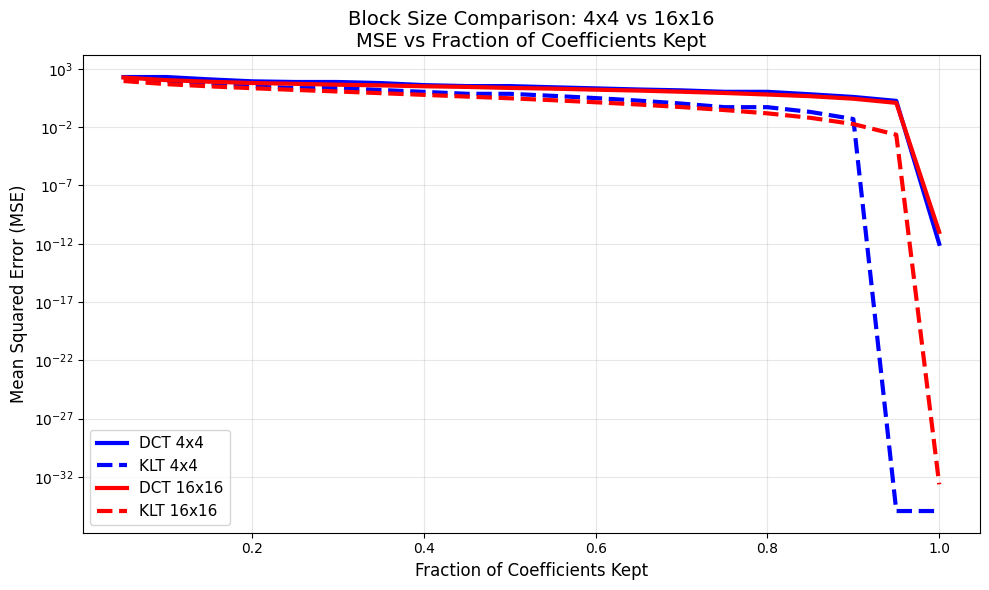

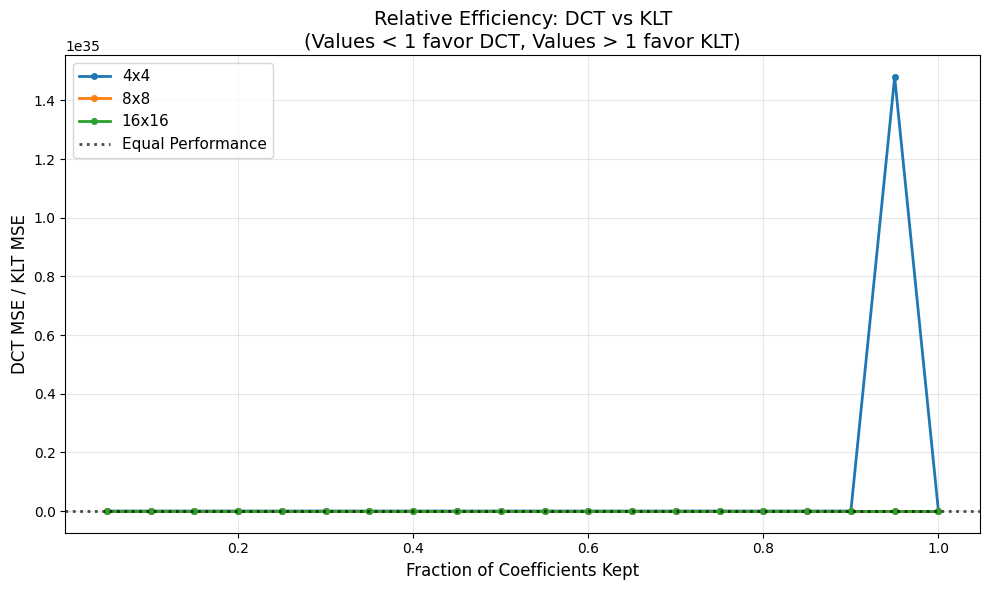

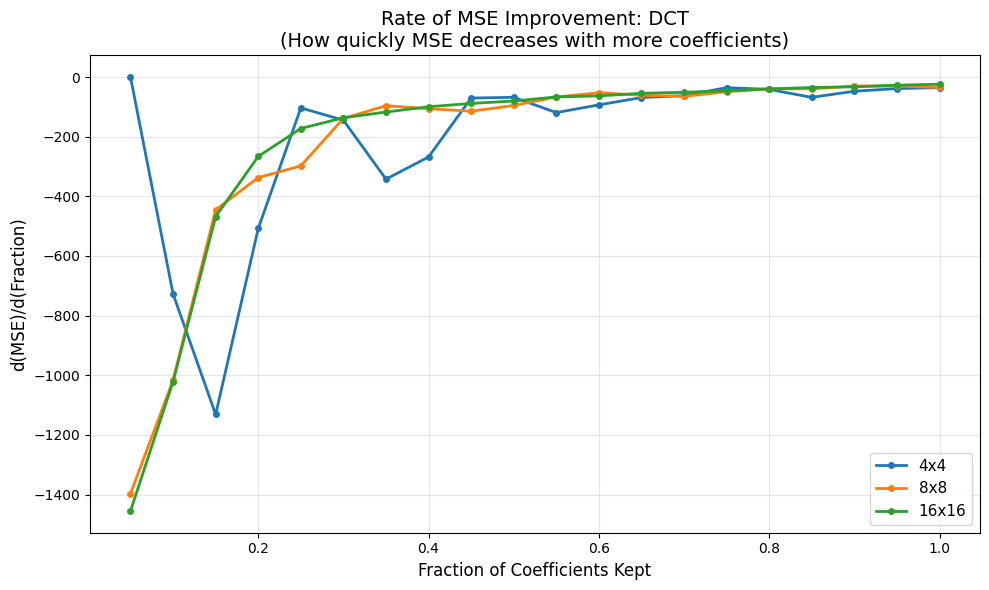

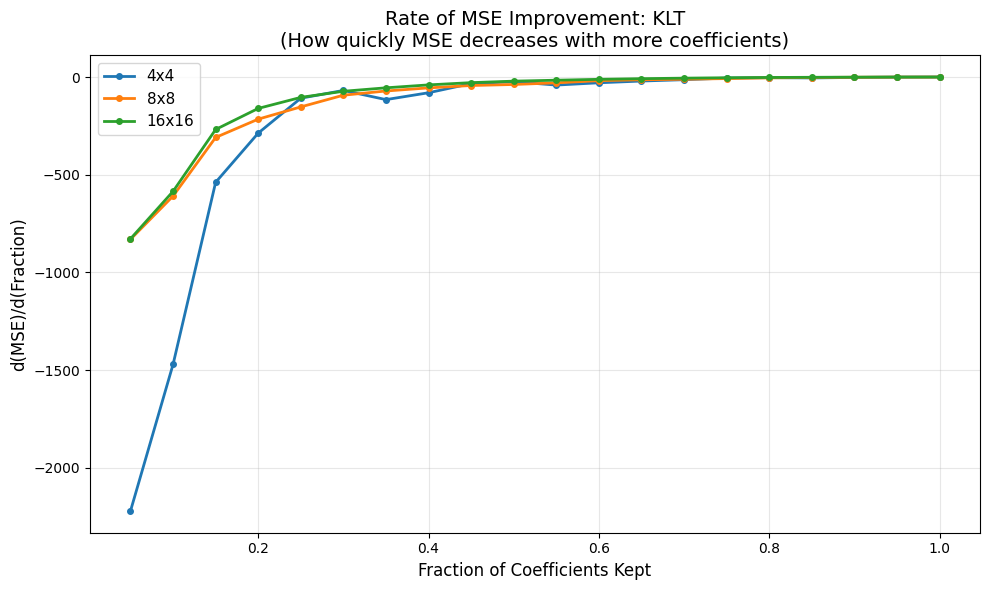

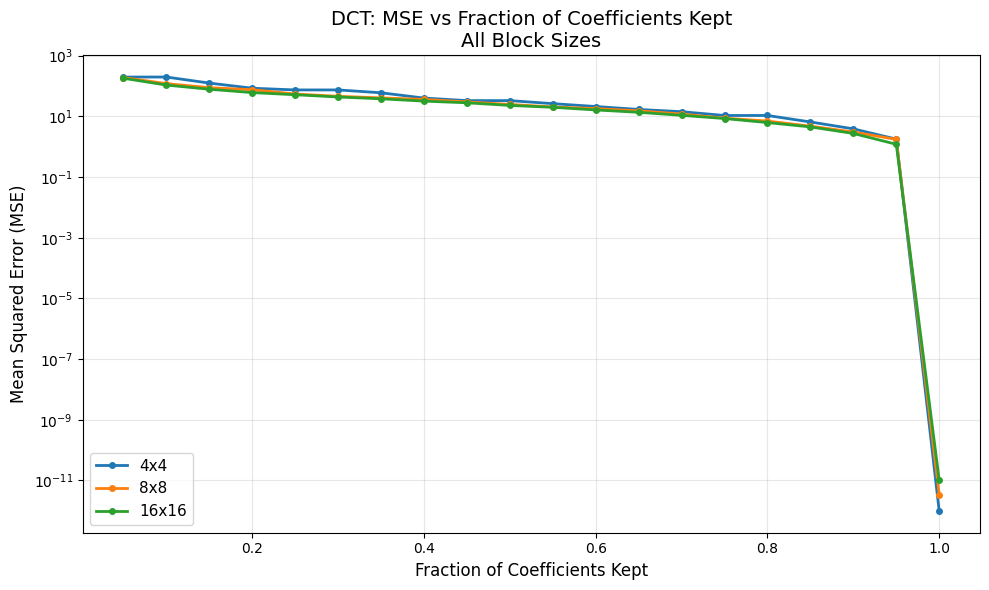

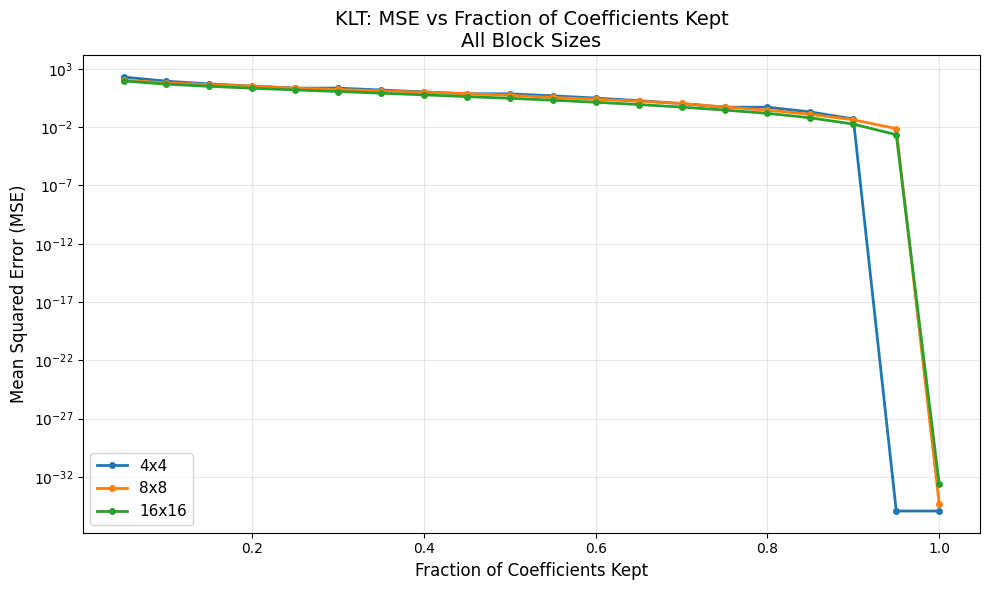

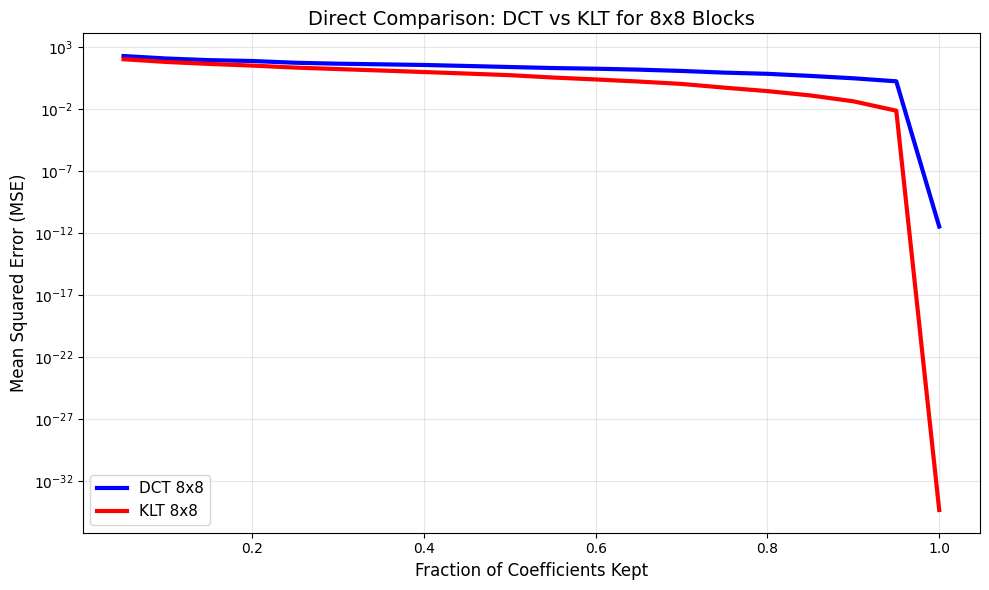


DETAILED MSE RESULTS

Block Size: 4x4
--------------------------------------------------
Fraction |    DCT MSE    |    KLT MSE    | DCT/KLT Ratio
--------------------------------------------------
   0.10  |       197.84 |        86.81 |         2.28
   0.20  |        84.69 |        32.94 |         2.57
   0.30  |        74.33 |        22.11 |         3.36
   0.50  |        33.05 |         7.21 |         4.59
   0.70  |        14.25 |         1.05 |        13.62
   0.90  |         3.88 |         0.05 |        78.46

Block Size: 8x8
--------------------------------------------------
Fraction |    DCT MSE    |    KLT MSE    | DCT/KLT Ratio
--------------------------------------------------
   0.10  |       120.06 |        63.10 |         1.90
   0.20  |        75.54 |        32.19 |         2.35
   0.30  |        45.76 |        16.91 |         2.71
   0.50  |        24.70 |         5.43 |         4.55
   0.70  |        11.93 |         1.07 |        11.13
   0.90  |         3.05 |       

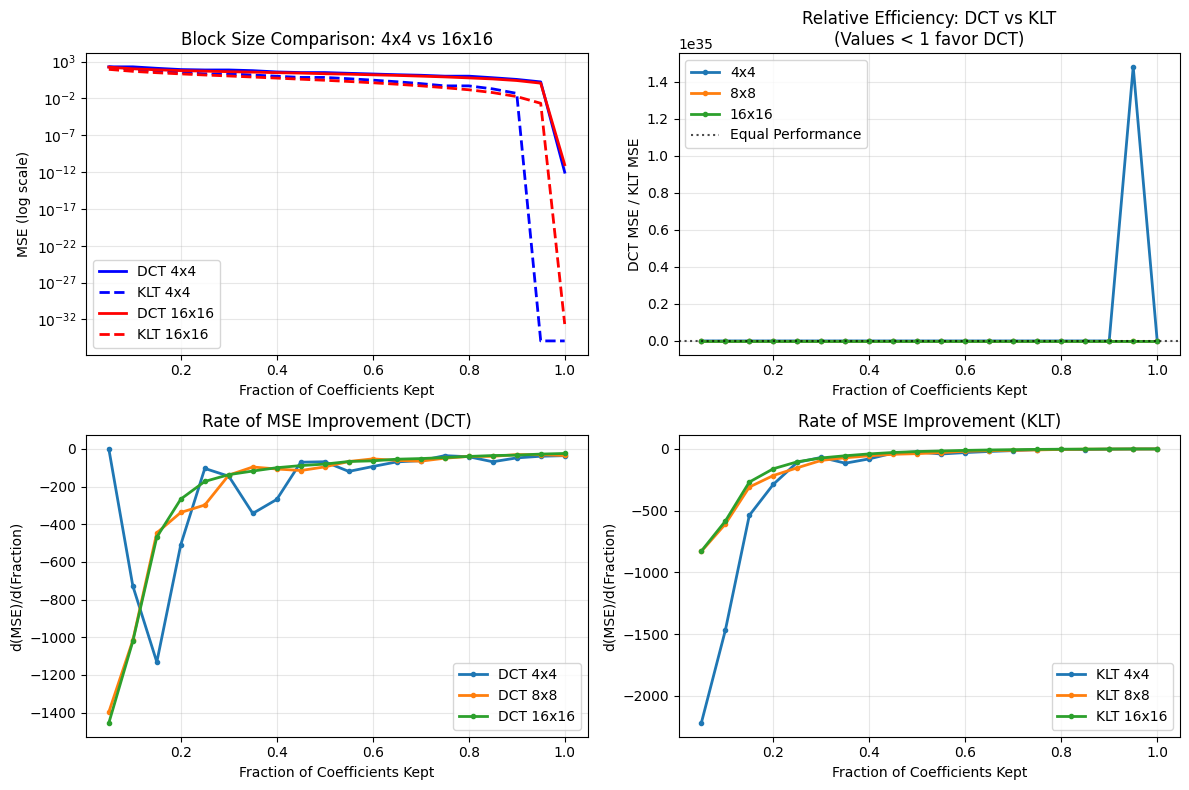


Analysis Complete!


In [15]:


def extract_non_overlapping_blocks(image, N):
    """Extract non-overlapping N x N blocks from image"""
    H, W = image.shape
    # Crop image to make it divisible by N
    H_new = (H // N) * N
    W_new = (W // N) * N
    image_cropped = image[:H_new, :W_new]
    
    blocks = []
    positions = []
    for i in range(0, H_new, N):
        for j in range(0, W_new, N):
            block = image_cropped[i:i+N, j:j+N].astype(np.float32)
            blocks.append(block)
            positions.append((i, j))
    
    return np.array(blocks), positions, (H_new, W_new)

def reconstruct_from_blocks(blocks, positions, image_shape):
    """Reconstruct image from blocks"""
    H, W = image_shape
    reconstructed = np.zeros((H, W), dtype=np.float32)
    for (i, j), block in zip(positions, blocks):
        reconstructed[i:i+block.shape[0], j:j+block.shape[1]] = block
    return reconstructed

def zigzag_mask(N, retain_count):
    """Create zigzag scanning mask for DCT coefficients"""
    mask = np.zeros((N, N), dtype=bool)
    coordinates = []
    
    # Generate zigzag coordinates
    for sum_idx in range(N + N - 1):
        if sum_idx % 2 == 0:  # Even sum: going up
            for i in range(min(sum_idx, N-1), max(0, sum_idx - (N-1)) - 1, -1):
                j = sum_idx - i
                if j < N:
                    coordinates.append((i, j))
        else:  # Odd sum: going down
            for j in range(min(sum_idx, N-1), max(0, sum_idx - (N-1)) - 1, -1):
                i = sum_idx - j
                if i < N:
                    coordinates.append((i, j))
    
    # Set mask for retained coefficients
    for idx in range(min(retain_count, len(coordinates))):
        i, j = coordinates[idx]
        mask[i, j] = True
    
    return mask

def apply_dct_with_coefficient_retention(blocks, retain_ratio):
    """
    Apply DCT to blocks and retain only a fraction of coefficients using zigzag scanning
    """
    N = blocks.shape[1]
    transformed_blocks = []
    
    for block in blocks:
        # Zero-mean the block
        block_zero_mean = block - block.mean()
        
        # Apply DCT
        coeffs = dct2(block_zero_mean)
        
        # Determine number of coefficients to retain
        total_coeffs = N * N
        retain_count = int(total_coeffs * retain_ratio)
        
        # Create zigzag mask
        mask = zigzag_mask(N, retain_count)
        
        # Retain only selected coefficients
        retained_coeffs = coeffs * mask
        
        # Apply inverse DCT
        reconstructed_block = idct2(retained_coeffs)
        
        # Add back the mean
        reconstructed_block += block.mean()
        transformed_blocks.append(reconstructed_block)
    
    return np.array(transformed_blocks)

def apply_klt_with_coefficient_retention(blocks, klt_basis, retain_ratio):
    """
    Apply KLT to blocks and retain only a fraction of coefficients (largest magnitude)
    """
    N = blocks.shape[1]
    transformed_blocks = []
    
    for block in blocks:
        # Zero-mean the block
        block_zero_mean = block - block.mean()
        
        # Apply KLT: project onto KLT basis
        block_flat = block_zero_mean.reshape(-1)
        coeffs = klt_basis.T @ block_flat
        coeffs_2d = coeffs.reshape(N, N)
        
        # Determine number of coefficients to retain
        total_coeffs = N * N
        retain_count = int(total_coeffs * retain_ratio)
        
        # Retain coefficients with largest magnitude
        coeffs_flat = coeffs_2d.reshape(-1)
        indices = np.argsort(np.abs(coeffs_flat))[::-1][:retain_count]
        mask = np.zeros(total_coeffs, dtype=bool)
        mask[indices] = True
        mask_2d = mask.reshape(N, N)
        
        # Retain only selected coefficients
        retained_coeffs = coeffs_2d * mask_2d
        
        # Inverse KLT: reconstruct from retained coefficients
        coeffs_flat_retained = retained_coeffs.reshape(-1)
        reconstructed_flat = klt_basis @ coeffs_flat_retained
        reconstructed_block = reconstructed_flat.reshape(N, N)
        
        # Add back the mean
        reconstructed_block += block.mean()
        transformed_blocks.append(reconstructed_block)
    
    return np.array(transformed_blocks)

def calculate_mse(original, reconstructed):
    """Calculate Mean Squared Error between original and reconstructed"""
    return np.mean((original - reconstructed) ** 2)

# Load image
img = data.camera().astype(np.float32)

# Define block sizes to test
block_sizes = [4, 8, 16]
retention_ratios = np.linspace(0.05, 1.0, 20)  # From 5% to 100%

# Store results
results_dct = {bs: [] for bs in block_sizes}
results_klt = {bs: [] for bs in block_sizes}

print("MSE Analysis for Different Block Sizes")
print("=" * 80)

for block_size in block_sizes:
    print(f"\nProcessing block size: {block_size}x{block_size}")
    
    # Extract non-overlapping blocks
    blocks, positions, image_shape = extract_non_overlapping_blocks(img, block_size)
    print(f"  Extracted {len(blocks)} blocks")
    
    # Train KLT basis for this block size
    zero_mean_blocks = np.array([block - block.mean() for block in blocks])
    V, w = klt_from_patches(zero_mean_blocks.reshape(-1, block_size, block_size))
    klt_basis = V
    
    # Test different retention ratios
    for ratio in retention_ratios:
        # Apply DCT
        dct_reconstructed = apply_dct_with_coefficient_retention(blocks, ratio)
        dct_image = reconstruct_from_blocks(dct_reconstructed, positions, image_shape)
        dct_mse = calculate_mse(img[:image_shape[0], :image_shape[1]], dct_image)
        results_dct[block_size].append(dct_mse)
        
        # Apply KLT
        klt_reconstructed = apply_klt_with_coefficient_retention(blocks, klt_basis, ratio)
        klt_image = reconstruct_from_blocks(klt_reconstructed, positions, image_shape)
        klt_mse = calculate_mse(img[:image_shape[0], :image_shape[1]], klt_image)
        results_klt[block_size].append(klt_mse)
    
    print(f"  Completed {len(retention_ratios)} retention ratios")

plt.figure(figsize=(10, 6))
plt.plot(retention_ratios, results_dct[4], 'b-', linewidth=3, label='DCT 4x4')
plt.plot(retention_ratios, results_klt[4], 'b--', linewidth=3, label='KLT 4x4')
plt.plot(retention_ratios, results_dct[16], 'r-', linewidth=3, label='DCT 16x16')
plt.plot(retention_ratios, results_klt[16], 'r--', linewidth=3, label='KLT 16x16')
plt.xlabel('Fraction of Coefficients Kept', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.title('Block Size Comparison: 4x4 vs 16x16\nMSE vs Fraction of Coefficients Kept', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.savefig('block_size_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Relative Efficiency - DCT vs KLT
plt.figure(figsize=(10, 6))
efficiency_ratio = {}
for block_size in block_sizes:
    efficiency_ratio[block_size] = [dct/klt if klt > 0 else 1.0 
                                   for dct, klt in zip(results_dct[block_size], results_klt[block_size])]
    plt.plot(retention_ratios, efficiency_ratio[block_size], 
             'o-', linewidth=2, markersize=4, label=f'{block_size}x{block_size}')

plt.axhline(y=1.0, color='black', linestyle=':', alpha=0.7, linewidth=2, label='Equal Performance')
plt.xlabel('Fraction of Coefficients Kept', fontsize=12)
plt.ylabel('DCT MSE / KLT MSE', fontsize=12)
plt.title('Relative Efficiency: DCT vs KLT\n(Values < 1 favor DCT, Values > 1 favor KLT)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('relative_efficiency.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Rate of MSE Improvement - DCT
plt.figure(figsize=(10, 6))
for block_size in block_sizes:
    derivative = np.gradient(results_dct[block_size], retention_ratios)
    plt.plot(retention_ratios, derivative, 
             'o-', linewidth=2, markersize=4, label=f'{block_size}x{block_size}')

plt.xlabel('Fraction of Coefficients Kept', fontsize=12)
plt.ylabel('d(MSE)/d(Fraction)', fontsize=12)
plt.title('Rate of MSE Improvement: DCT\n(How quickly MSE decreases with more coefficients)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('dct_improvement_rate.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 4: Rate of MSE Improvement - KLT
plt.figure(figsize=(10, 6))
for block_size in block_sizes:
    derivative = np.gradient(results_klt[block_size], retention_ratios)
    plt.plot(retention_ratios, derivative, 
             'o-', linewidth=2, markersize=4, label=f'{block_size}x{block_size}')

plt.xlabel('Fraction of Coefficients Kept', fontsize=12)
plt.ylabel('d(MSE)/d(Fraction)', fontsize=12)
plt.title('Rate of MSE Improvement: KLT\n(How quickly MSE decreases with more coefficients)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('klt_improvement_rate.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional Plot 5: All DCT results together
plt.figure(figsize=(10, 6))
for block_size in block_sizes:
    plt.plot(retention_ratios, results_dct[block_size], 
             'o-', linewidth=2, markersize=4, label=f'{block_size}x{block_size}')

plt.xlabel('Fraction of Coefficients Kept', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.title('DCT: MSE vs Fraction of Coefficients Kept\nAll Block Sizes', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.savefig('dct_all_blocks.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional Plot 6: All KLT results together
plt.figure(figsize=(10, 6))
for block_size in block_sizes:
    plt.plot(retention_ratios, results_klt[block_size], 
             'o-', linewidth=2, markersize=4, label=f'{block_size}x{block_size}')

plt.xlabel('Fraction of Coefficients Kept', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.title('KLT: MSE vs Fraction of Coefficients Kept\nAll Block Sizes', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.savefig('klt_all_blocks.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional Plot 7: Direct comparison for 8x8 blocks (most common)
plt.figure(figsize=(10, 6))
plt.plot(retention_ratios, results_dct[8], 'b-', linewidth=3, label='DCT 8x8')
plt.plot(retention_ratios, results_klt[8], 'r-', linewidth=3, label='KLT 8x8')
plt.xlabel('Fraction of Coefficients Kept', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.title('Direct Comparison: DCT vs KLT for 8x8 Blocks', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.savefig('dct_vs_klt_8x8.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed results table
print("\n" + "=" * 80)
print("DETAILED MSE RESULTS")
print("=" * 80)

# Create a table for key retention ratios
key_ratios = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]

for block_size in block_sizes:
    print(f"\nBlock Size: {block_size}x{block_size}")
    print("-" * 50)
    print("Fraction |    DCT MSE    |    KLT MSE    | DCT/KLT Ratio")
    print("-" * 50)
    
    for target_ratio in key_ratios:
        # Find closest available ratio
        idx = np.argmin(np.abs(retention_ratios - target_ratio))
        ratio = retention_ratios[idx]
        dct_mse = results_dct[block_size][idx]
        klt_mse = results_klt[block_size][idx]
        ratio_mse = dct_mse / klt_mse if klt_mse > 0 else float('inf')
        
        print(f"   {ratio:4.2f}  | {dct_mse:12.2f} | {klt_mse:12.2f} | {ratio_mse:12.2f}")

# Additional analysis: Find where MSE drops below certain thresholds
print("\n" + "=" * 80)
print("PERFORMANCE THRESHOLD ANALYSIS")
print("=" * 80)

mse_thresholds = [100, 50, 20, 10]

for threshold in mse_thresholds:
    print(f"\nMinimum fraction to achieve MSE < {threshold}:")
    print("Block Size |   DCT Fraction   |   KLT Fraction   ")
    print("-" * 45)
    
    for block_size in block_sizes:
        # Find where MSE drops below threshold
        dct_below = [r for r, mse in zip(retention_ratios, results_dct[block_size]) if mse < threshold]
        klt_below = [r for r, mse in zip(retention_ratios, results_klt[block_size]) if mse < threshold]
        
        dct_min = min(dct_below) if dct_below else float('inf')
        klt_min = min(klt_below) if klt_below else float('inf')
        
        print(f"  {block_size}x{block_size}  | {dct_min:15.3f} | {klt_min:15.3f}")

# Create final summary plot focusing on key insights
plt.figure(figsize=(12, 8))

# Plot for 4x4 and 16x16 comparison
plt.subplot(2, 2, 1)
plt.plot(retention_ratios, results_dct[4], 'b-', linewidth=2, label='DCT 4x4')
plt.plot(retention_ratios, results_klt[4], 'b--', linewidth=2, label='KLT 4x4')
plt.plot(retention_ratios, results_dct[16], 'r-', linewidth=2, label='DCT 16x16')
plt.plot(retention_ratios, results_klt[16], 'r--', linewidth=2, label='KLT 16x16')
plt.xlabel('Fraction of Coefficients Kept')
plt.ylabel('MSE (log scale)')
plt.title('Block Size Comparison: 4x4 vs 16x16')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot efficiency comparison
plt.subplot(2, 2, 2)
efficiency_ratio = {}
for block_size in block_sizes:
    efficiency_ratio[block_size] = [dct/klt if klt > 0 else 1.0 
                                   for dct, klt in zip(results_dct[block_size], results_klt[block_size])]
    plt.plot(retention_ratios, efficiency_ratio[block_size], 
             'o-', linewidth=2, markersize=3, label=f'{block_size}x{block_size}')

plt.axhline(y=1.0, color='black', linestyle=':', alpha=0.7, label='Equal Performance')
plt.xlabel('Fraction of Coefficients Kept')
plt.ylabel('DCT MSE / KLT MSE')
plt.title('Relative Efficiency: DCT vs KLT\n(Values < 1 favor DCT)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot derivative to show rate of improvement
plt.subplot(2, 2, 3)
for block_size in block_sizes:
    derivative = np.gradient(results_dct[block_size], retention_ratios)
    plt.plot(retention_ratios, derivative, 'o-', linewidth=2, markersize=3, 
             label=f'DCT {block_size}x{block_size}')

plt.xlabel('Fraction of Coefficients Kept')
plt.ylabel('d(MSE)/d(Fraction)')
plt.title('Rate of MSE Improvement (DCT)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
for block_size in block_sizes:
    derivative = np.gradient(results_klt[block_size], retention_ratios)
    plt.plot(retention_ratios, derivative, 'o-', linewidth=2, markersize=3, 
             label=f'KLT {block_size}x{block_size}')

plt.xlabel('Fraction of Coefficients Kept')
plt.ylabel('d(MSE)/d(Fraction)')
plt.title('Rate of MSE Improvement (KLT)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAnalysis Complete!")




# Entropy Coding: Huffman vs. Arithmetic

In [27]:
import numpy as np

def entropy_from_p(p):
    q = p[p > 0]
    return float(-np.sum(q * np.log2(q)))

def pmf_from_counts(counts):
    p = counts.astype(np.float64)
    return p / p.sum() if p.sum() > 0 else p

def arithmetic_expected_bits(data, p):
    p_safe = np.maximum(p, 1e-12)
    return float(np.mean(-np.log2(p_safe[data])))


In [28]:
def compute_residuals_entropy(image):
    pred = predict_left(image)
    residuals = image.astype(np.int16) - pred.astype(np.int16)

    rmin, rmax = residuals.min(), residuals.max()
    counts, _ = np.histogram(residuals, bins=(rmax - rmin + 1),
                             range=(rmin - 0.5, rmax + 0.5))
    p = pmf_from_counts(counts)
    H = entropy_from_p(p)

    plt.figure(figsize=(6,4))
    plt.bar(np.arange(rmin, rmax + 1), p, width=1.0)
    plt.title(f"Residuals PMF — Entropy = {H:.3f} bits")
    plt.xlabel("Residual value")
    plt.ylabel("Probability")
    plt.tight_layout()
    plt.show()

    return H, p, rmin





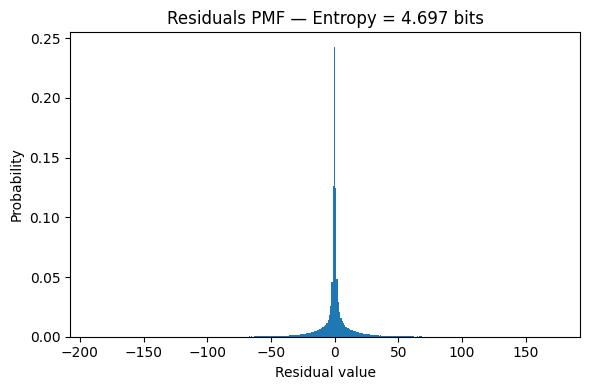

Residuals entropy H(R) = 4.697 bits
Average Huffman code length L̄ = 4.715 bits/symbol
Redundancy = 0.018 bits/symbol


In [29]:
import heapq

class Node:
    def __init__(self, symbol=None, prob=None, left=None, right=None):
        self.symbol = symbol
        self.prob = prob
        self.left = left
        self.right = right

    # to make nodes comparable in heap
    def __lt__(self, other):
        return self.prob < other.prob
    
def build_huffman_code(p):
    """Given PMF array p, build Huffman code dictionary {symbol: code}"""
    heap = [Node(i, prob) for i, prob in enumerate(p) if prob > 0]
    heapq.heapify(heap)

    # merge lowest two nodes until one root remains
    while len(heap) > 1:
        n1 = heapq.heappop(heap)
        n2 = heapq.heappop(heap)
        merged = Node(None, n1.prob + n2.prob, n1, n2)
        heapq.heappush(heap, merged)

    # traverse tree to assign binary codes
    root = heap[0]
    codes = {}

    def traverse(node, prefix=""):
        if node.symbol is not None:
            codes[node.symbol] = prefix or "0"  # handle single-symbol case
        else:
            traverse(node.left, prefix + "0")
            traverse(node.right, prefix + "1")

    traverse(root)
    return codes

def average_code_length(p, codes):
    lengths = np.array([len(codes[i]) for i in range(len(p)) if p[i] > 0])
    probs = np.array([p[i] for i in range(len(p)) if p[i] > 0])
    return float(np.sum(probs * lengths))

image = data.camera().astype(np.uint8)
H, p, rmin = compute_residuals_entropy(image)

codes = build_huffman_code(p)
L_avg = average_code_length(p, codes)

print(f"Residuals entropy H(R) = {H:.3f} bits")
print(f"Average Huffman code length L̄ = {L_avg:.3f} bits/symbol")
print(f"Redundancy = {L_avg - H:.3f} bits/symbol")



In [33]:
def arithmetic_encode(data, p, rmin):
    """
    Arithmetic encoding simulation.
    Returns the average code length in bits per symbol.
    """
    low = 0.0
    high = 1.0
    total_bits = 0
    
    # Create cumulative probability distribution
    cum_prob = np.cumsum(np.concatenate(([0], p)))
    
    for symbol in data:
        # Map residual value to index (residuals start at rmin)
        idx = symbol - rmin
        
        # Check if symbol is in our probability model
        if idx < 0 or idx >= len(p) or p[idx] == 0:
            # Fallback: use uniform distribution for unseen symbols
            range_width = high - low
            low = low + range_width * (idx / (len(p) + 1))
            high = low + range_width * (1 / (len(p) + 1))
        else:
            # Normal case: use our probability model
            range_width = high - low
            high = low + range_width * cum_prob[idx + 1]
            low = low + range_width * cum_prob[idx]
        
        # Count bits by checking how many bits are needed to represent the interval
        # A practical implementation would output bits when they become certain
        while high < 0.5 or low > 0.5:
            if high < 0.5:
                total_bits += 1
                low *= 2
                high *= 2
            elif low > 0.5:
                total_bits += 1
                low = 2 * (low - 0.5)
                high = 2 * (high - 0.5)
    
    # Final bits to specify the final interval
    # In practice, we'd need ~ceil(-log2(high-low)) bits
    final_interval_size = high - low
    if final_interval_size > 0:
        total_bits += int(np.ceil(-np.log2(final_interval_size)))
    
    return total_bits / len(data)


# Get residuals for arithmetic coding
pred = predict_left(image)
residuals = image.astype(np.int16) - pred.astype(np.int16)

# Flatten the residuals for encoding
residuals_flat = residuals.flatten()

# Calculate arithmetic coding performance
L_arithmetic = arithmetic_encode(residuals_flat, p, rmin)

print(f"Residuals entropy H(R) = {H:.3f} bits")
print(f"Average Huffman code length L̄ = {L_avg:.3f} bits/symbol")
print(f"Average Arithmetic code length = {L_arithmetic:.3f} bits/symbol")
print(f"Huffman redundancy = {L_avg - H:.3f} bits/symbol")
print(f"Arithmetic redundancy = {L_arithmetic - H:.3f} bits/symbol")

# Compare all methods
print("\nComparison:")
print(f"Entropy (theoretical limit): {H:.3f} bits/symbol")
print(f"Huffman coding: {L_avg:.3f} bits/symbol (redundancy: {L_avg - H:.3f})")
print(f"Arithmetic coding: {L_arithmetic:.3f} bits/symbol (redundancy: {L_arithmetic - H:.3f})")


Residuals entropy H(R) = 4.697 bits
Average Huffman code length L̄ = 4.715 bits/symbol
Average Arithmetic code length = 4.697 bits/symbol
Huffman redundancy = 0.018 bits/symbol
Arithmetic redundancy = 0.000 bits/symbol

Comparison:
Entropy (theoretical limit): 4.697 bits/symbol
Huffman coding: 4.715 bits/symbol (redundancy: 0.018)
Arithmetic coding: 4.697 bits/symbol (redundancy: 0.000)
